# Time Series Analysis with Python
This is a review of some basic time series analysis concepts using the pandas module. We look at the Google trends of the words 'diet', 'gym', and 'finance' and apply some simple time series analysis to analyze people's search pattern of these words over time.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# settings
from IPython.display import display

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.columns = ['year_month', 'diet', 'gym', 'finance']
df.head()

In [ ]:
# convert year-month column into datetime
df.month = pd.to_datetime(df.year_month)
df.set_index('year_month', inplace=True)

In [ ]:
df.head()

In [ ]:
df.plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

There's seasonality within each year in all three categories. We expect people to look up gym, diet, and finance more frequently early in the new year as they follow through on their new year's resolution. As interest wane over time, searches for these keywords are likely to also decrease. We can look at this more systematically by looking at a tabulation of the within-year peaks and troughs across each month for each term.

In [ ]:
# create year and month columns
df['year_month'] = df.index.values
s = df['year_month'].apply(lambda x: x.split('-'))
df['year'] = s.apply(lambda x: x[0])
df['month'] = s.apply(lambda x: x[1])

In [ ]:
def peaktrough_month(col, param='max'):
    print('Month corresponding to {0} of "{1}" in a year'.format(param, col))
    
    if param=='max':
        groupby_ops = df.loc[df.groupby(['year'])[col].idxmax()]
    elif param=='min':
        groupby_ops = df.loc[df.groupby(['year'])[col].idxmin()]
    else:
        print("Set param to max or min only")
    
    return (groupby_ops.loc[:, [col, 'month']]
                       .groupby('month')
                       .count())

In [ ]:
display(peaktrough_month('diet', param='max'))
peaktrough_month('diet', param='min')

In [ ]:
display(peaktrough_month('gym', param='max'))
peaktrough_month('gym', param='min')

In [ ]:
display(peaktrough_month('finance', param='max'))
peaktrough_month('finance', param='min')

Here we see that, within a year, the peak number of times the word diet was searched was in January (month 1). For one year it falls on February, which is still pretty early in the new year. Conversely, the word diet was searched the fewest times in December (month 12) for all years.

People certainly look up 'gym' more frequently in January, but there appears to be no single month where their interest in searching for gym begin to wane. It does, however, show that people lose interest some time at the beginning of summer and at the last quarter of the year

For the 'finance' term, we see people take an interest early in the year and lose interest in the holidays.

## Box plots by month

An even better way to see this is to plot the data by month:

In [ ]:
df.boxplot(column=['diet'], by=['month']);

In [ ]:
df.boxplot(column=['gym'], by=['month']);

In [ ]:
df.boxplot(column=['finance'], by=['month']);

## Rolling average
Plot rolling mean to observe the general trend in the search count over time.

In [ ]:
def rolling_mean(col):
    rolling_mean_col = 'rolling_mean_{}'.format(col)
    df[rolling_mean_col] = df[col].rolling(12).mean()
    
cols = ['diet', 'gym', 'finance']
for col in cols:
    rolling_mean(col)

In [ ]:
df.head(n=24)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13,10));
df[['diet', 'rolling_mean_diet']].plot(ax=axes[0],  color=['red', 'green']);
df[['gym', 'rolling_mean_gym']].plot(ax=axes[1], color=['purple', 'red']);
df[['finance', 'rolling_mean_finance']].plot(ax=axes[2]);

A goal of time series analysis is to investigate the correlation between variables in a way that controls for seasonality and trends. In our example, perhaps we would like to examine the extent to which peoples searches of "diet" and "gym" are correlated. Our intuition tells us that they should be correlatd. We can check this empircally using our data.

Before we do this, let's define some common features of time series. First, they are characterized by having a __trend__, which is the long term change in the mean level. We can see this for the "gym" term above with the slight increase in the rolling mean we computed over time. Second, time series tend to exhibit __seasonality__, which is defined as the variation in the mean that is periodic in nature. This is most obvious for the "diet" term for which searches of it increases in January but appears to wane just before the new year. Time series can also exhibits __cyclicality__, which is oscillation in the data that isn't of fixed period. Cyclicality is different from seasonality in that the latter occurs at fixed known intervals (activity in the holiday season is distinct from any other period and occurs every year). Finally, time series data can be __noisy__, which is just the unpredictable variation in the data.

## Correlation
 Suppose we were to look at a simple cross-sectional correlation between the term popularity of "diet" and "gym" in the raw data.

In [ ]:
df[['diet', 'gym', 'finance']].plot(figsize=(20,10), linewidth=5, fontsize=20);
plt.xlabel('Year', fontsize=20);

In [ ]:
df[cols].corr()

The cross-sectional correlation suggests that search for 'diet' and 'gym' are negatively correlated. This goes against our intuition in that we expect people interested in fitness to be jointly interested in going to the gym and eating wholesome food. Let's plot the trends to investigate why the correlation might be negative

In [ ]:
df[['rolling_mean_diet', 'rolling_mean_gym']].plot(figsize=(20,10));

There's a general upward trend in search for gym, whereas searches for diet appear to have peaks and troughs over the horizon of our data. This could be the reason why these two terms are negatively correlated. Let's confirm this by looking at the correlation between their rolling means.

In [ ]:
df[['rolling_mean_diet', 'rolling_mean_gym']].corr()

Aha! so the negative correlation between these two terms seem to be due to long term trends. If we were to remove the trend from the time series, we should see the intuitive positive correlation. We can do this by either subtracting the rolling means or taking the first difference

Detrend by subtracting rolling mean then look at seasonality correlation across terms

In [ ]:
for c in cols:
    print("Detrending", c)
    df['detrend_{}'.format(c)] = df[c] - df['rolling_mean_{}'.format(c)]

df[['detrend_{}'.format(c) for c in cols]].corr()

Detrend by first different then look at seasonality correlation

In [ ]:
df[cols].diff().corr()

## Autocorrelation

Autocorrelation measures the extent to which a time series depends on some lagged version of itself. With time series exhibiting strong seasonality, we expect there to be a pattern of strong autocorrelation at fixed intervals in the data. Let's confirm this by creating the autocorrelation plot for each term in our data.

In [ ]:
def xticks_year():
    """Make x-ticks every 12 steps to correspond with calendar year"""
    x = [tick for tick in range(160)]
    plt.xticks(np.arange(min(x), max(x)+1, 12.0));

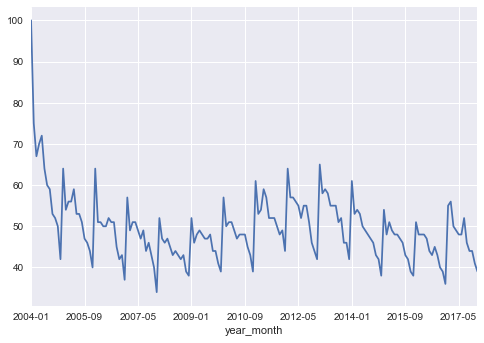

In [174]:
df['diet'].plot();

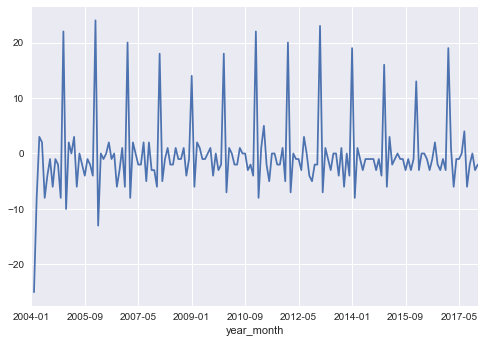

In [175]:
df['diet'].diff().plot();

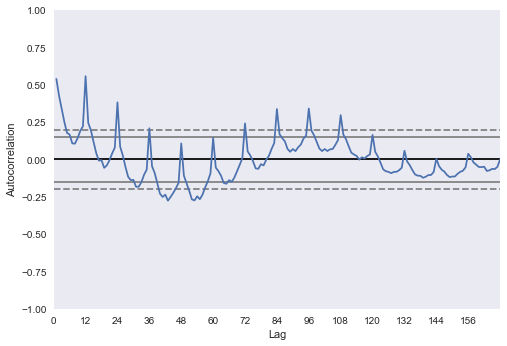

In [176]:
pd.plotting.autocorrelation_plot(df['diet']);
xticks_year()

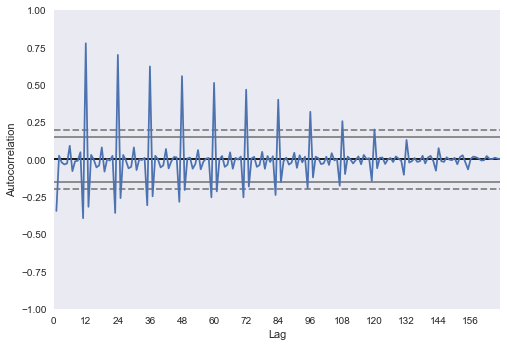

In [178]:
pd.plotting.autocorrelation_plot(df['diet'].diff()[1:]);
xticks_year()

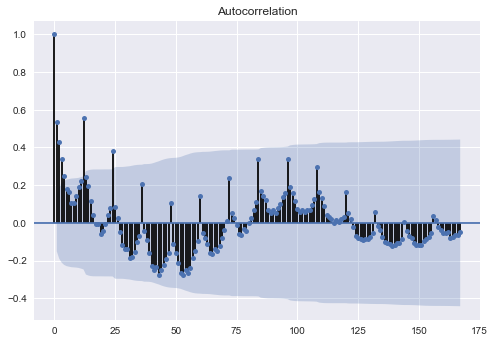

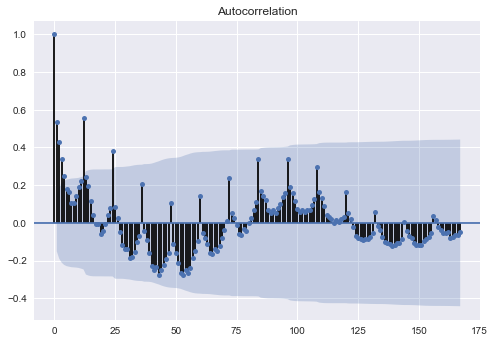

In [168]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['diet'])

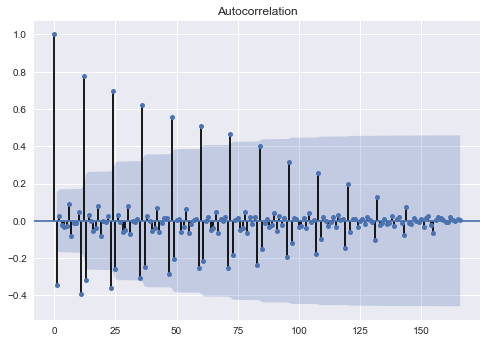

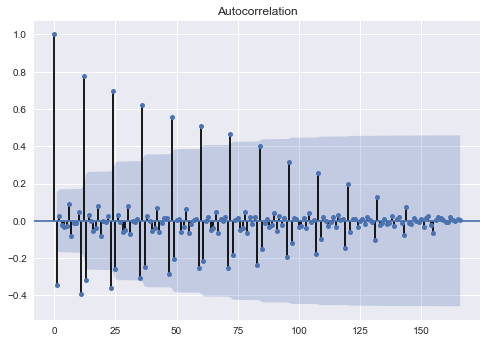

In [181]:
df['diet_first_diff'].dropna(inplace=True)
plot_acf(df['diet_first_diff'])

This is exactly what we expected: we observe a sharp peak in the autocorrelation plot for diet at intervals of 12. This suggests that the count of the searches for 'diet' at time t is highly correlated with the count for the same term at time t + 12, which gives evidence to the seasonality that characterizes the search count for this term.

The autocorrelation plot also gives us information on how useful past information is today. If the autocorrelation is statistically different from zero (i.e. falls outside the confidence bands at 99% in this example), then data from that period has some predictive power. In our plot above, it seems that information from 24 months back are predictive of current values.



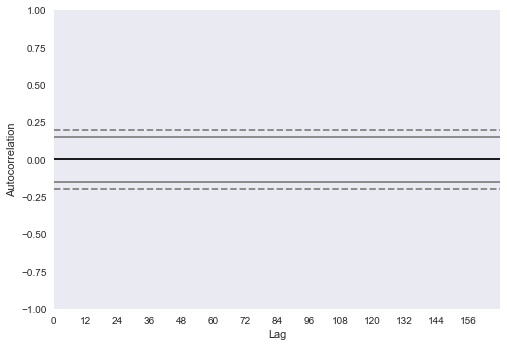

In [171]:
pd.plotting.autocorrelation_plot(df['gym'].diff());
xticks_year()

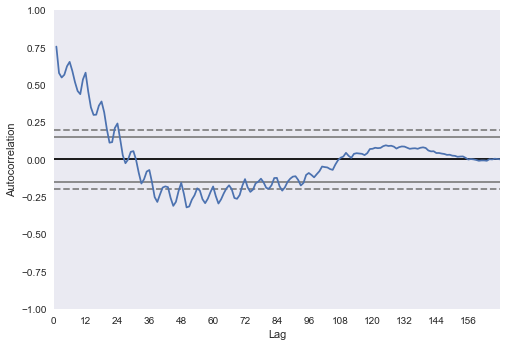

In [170]:
pd.plotting.autocorrelation_plot(df['finance']);
xticks_year()

We observe similar, but not as strong patterns for 'gym' and 'finance'

# Extra

## Exponentially weighted moving average

In [ ]:
df['diet'].ewm(alpha=0.5).mean().plot();
df['diet'].plot();

In [ ]:
df['diet'].ewm(alpha=0.99999).mean().plot();
df['diet'].plot();

In [ ]:
df['diet'].ewm(alpha=0.2).mean().plot();
df['diet'].plot();

## Expanding window moving average

In [ ]:
diet_exp = df['diet'].expanding(min_periods=5)
diet_exp.mean().plot()

In [ ]:
diet_exp = df['diet'].expanding(min_periods=1)
diet_exp.mean().plot()

In [ ]:
diet_exp = df['diet'].expanding(min_periods=20)
diet_exp.mean().plot()

In [ ]:
dfff = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})
dfff

In [ ]:
dfff.expanding(1).mean()

In [ ]:
dfff.expanding(2).mean()

In [ ]:
dfff.expanding(3).mean()

## Random Walk

In [23]:
def rand_walk_generator(num_obs):

    rand_walk_vals = []
    s = np.random.normal(0, 1)
    
    rand_walk_vals.append(s)
    
    for obs in range(num_obs):
        
        print("Index num: ", obs)
        
        prev_val = rand_walk_vals[obs]
        print("Previous val", prev_val)
        
        new_val = prev_val + np.random.normal(0, 1)
        
        rand_walk_vals.append(new_val)

        print(rand_walk_vals)

print(rand_walk_generator(100))

Index num:  0
Previous val 0.2520126248711869
[0.2520126248711869, 0.12305460813982405]
Index num:  1
Previous val 0.12305460813982405
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271]
Index num:  2
Previous val -0.5292997283666271
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271, -1.0493358991862056]
Index num:  3
Previous val -1.0493358991862056
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271, -1.0493358991862056, -0.19019090559912843]
Index num:  4
Previous val -0.19019090559912843
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271, -1.0493358991862056, -0.19019090559912843, 0.3707014716714644]
Index num:  5
Previous val 0.3707014716714644
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271, -1.0493358991862056, -0.19019090559912843, 0.3707014716714644, -0.5726521222457376]
Index num:  6
Previous val -0.5726521222457376
[0.2520126248711869, 0.12305460813982405, -0.5292997283666271, -1.0493358991862056, -0.19019090559912843

In [ ]:
# Plot random walk